In [2]:
%run common.py

Planning start time: Jul 16, 14:40 (1468669247)


<a id='toc'></a>
## Содержание

1. [Вывозные локомотивы](#vyv)
2. [Сохранение времени явки бригады при перепланировании](#pr_save)
3. [Ограничение на пересылку локомотивов резервом](#res)

<a id='vyv'></a>

## Вывозные локомотивы [ToC](#toc)

### Задания

Войтенко/Фрольцову:
1. Составить список локомотивов, которые работают на Восточном полигоне в вывозном движении. Для каждого локомотива указать номер, серию, ЕСР-код и название депо приписки.

Вздыхалкину/Науменко:
1. Разработать сущность онтологии, в которой хранить список вывозных локомотивов.

Башанову/Каштанову:
1. Разработать форму в АРМе Технолога, в которой показывать вывозные локомотивы.
2. Реализовать возможность редактирования списка вывозных локомотивов через эту форму (добавление / удаление).

Костенко:
1. Загрузить исходный справочник вывозных локомотивов в разработанную сущность.
2. Передавать вывозные локомотивы в планировщик с типом 2.

Смилге:
1. Реализовать алгоритм планирования вывозных локомотивов в планировщике.

### Алгоритм планирования вывозных локомотивов

1.	Локомотивы с типом «Вывозной» (это локомотивы со значением атрибута type = 2 в сообщении loco_attributes) должны работать преимущественно на коротких локомотивных слотах. Такие локомотивы чаще всего используются для развоза поездов внутри одного-двух УОЛБов.
2.	По этому критерию локомотиву дается добавка в функцию полезности, если это вывозной локомотив, а время хода по локомотивному слоту – небольшое.
3.	В качестве «серединного» значения выбрано время хода в 16 часов. Это связано с тем, что время хода по одному УОЛБу – примерно 6-8 часов. Соответственно, при таком выборе «длинными» будут считаться маршруты длиннее двух УОЛБов.
4. При расчете функции полезности при назначении локомотива на поезд для вывозных локомотивов прибавлять слагаемое $f(t)=\frac{2}{1+\exp⁡{(k(t-t_0))}}-1$, где $t$ – время хода по всему локомотивному слоту, выраженное в часах, $t_0=16$. Слагаемое входит в выражение для функции полезности только для локомотивов с типом «вывозной».
4. Из графика этой функции (см. ниже) видно, что при небольших временах хода по слоту (до 10 часов) вывозным локомотивам будет, по сути, добавляться +1 в функцию полезности, а при больших временах (больше 20 часов) – добавляться -1. Такая модель будет соответствовать реальным требованиям к планированию.
6.	На картинке приведено семейство графиков в зависимости от значения коэффициента под экспонентой (k). В формуле выше этот коэффициент равен 1. Его значение влияет на то, насколько график будет растянут возле среднего значения времени хода. Предлагается выбрать значение $k = 1.0$, а затем поменять в случае необходимости. Видно, что при больших k будет уменьшаться длина слотов, для которых будет добавка +1, с увеличением длины эта добавка будет убывать быстрее.

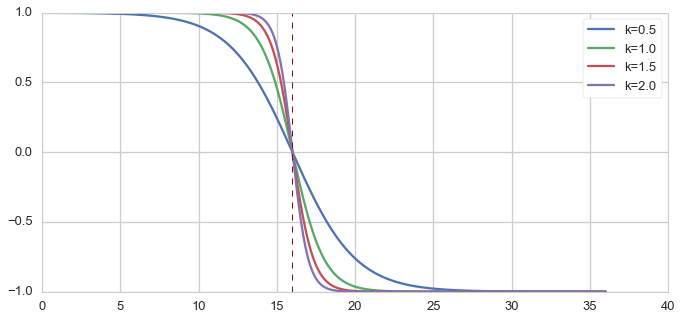

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

x0 = 16
x = np.linspace(0, 36, 1000)
plt.figure(figsize=(10, 5))
sns.set(style='whitegrid', context='talk')
sns.set_color_codes('dark')
for k in np.linspace(0.5, 2, 4):
    y = 2 / (1 + np.exp(k * (x - x0))) - 1
    plt.plot(x, y, label='k=%.1f' % k)
    
plt.plot([x0] * 20, np.linspace(-1, 1, 20), 'r--', lw=1.0)
plt.legend(frameon=True)
plt.show()

### Примеры планирования вывозных локомотивов

На плече Мариинск - Борзя работают вывозные локомотивы серии 2ЭС5К депо приписки Вихоревка. Эти локомотивы имеют номера от 80 до 87 включительно.

In [4]:
cols = ['loco', 'number', 'ser_name', 'depot_name', 'loc_name']
loco_info['ser_name'] = loco_info.series.map(loco_series.set_index('ser_id').ser_name)
loco_info.ser_name.fillna('-1', inplace=True)
loco_info['depot_name'] = loco_info.depot.map(st_names.name)
vyv = loco_info[(loco_info.ser_name.apply(lambda x: 'ЭС5К' in x)) & (loco_info.depot_name == 'ВИХОРЕВКА')
          & (loco_info.number >= 80) & (loco_info.number < 88)].sort_values(['depot_name', 'number'])
#nice_print(vyv, cols=cols, num=True)
vyv[cols]

,loco,number,ser_name,depot_name,loc_name
2004,200200031392,80,2ЭС5К,ВИХОРЕВКА,УЛАН-УДЭ
1168,200200100898,81,2ЭС5К,ВИХОРЕВКА,ЛЕНА
1631,200200090702,83,2ЭС5К,ВИХОРЕВКА,КАСЬЯНОВКА - ЧЕРЕМХОВО
921,200200080455,84,2ЭС5К,ВИХОРЕВКА,БАТАРЕЙНАЯ - МЕГЕТ
1645,200200058242,85,2ЭС5К,ВИХОРЕВКА,ИРКУТСК-СОРТИРОВОЧНЫЙ
1324,200200058339,86,2ЭС5К,ВИХОРЕВКА,ИРКУТСК-СОРТИРОВОЧНЫЙ


In [5]:
cols = ['loco', 'number', 'ser_name', 'regions', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'train']
loco_plan['ser_name'] = loco_plan.series.map(loco_series.set_index('ser_id').ser_name)
loco_plan['depot_name'] = loco_plan.depot.map(st_names.name)
a = loco_plan[loco_plan.loco.isin(vyv.loco)][cols]
start_st = a.drop_duplicates(subset=['loco', 'train'])
end_st = a.drop_duplicates(subset=['loco', 'train'], keep='last')
trips = start_st[['loco', 'regions', 'train', 'number', 'ser_name', 'st_from_name', 'time_start']].set_index(['loco', 'train'])\
    .join(end_st[['loco', 'train', 'st_to_name', 'time_end']].set_index(['loco', 'train']))\
    .reset_index()[cols].sort_values('number')
    
trips['tt'] = np.round(((trips.time_end - trips.time_start) / 3600), 2)
trips

,loco,number,ser_name,regions,st_from_name,st_to_name,time_start,time_end,train,tt
0,200200100898,81,2ЭС5К,['2002119301'],ЛЕНА,БРАТСК,1468682100,1468721635,88880002034735,10.98
1,200200090702,83,2ЭС5К,['2002119299'],КАСЬЯНОВКА,ЧЕРЕМХОВО,1468668000,1468668833,200022565153,0.23
2,200200090702,83,2ЭС5К,['2002119299'],ЧЕРЕМХОВО,ИРКУТСК-СОРТИРОВОЧНЫЙ,1468716000,1468724874,88880006284556,2.46
3,200200080455,84,2ЭС5К,['2002119299'],БАТАРЕЙНАЯ,МАРИИНСК,1468667340,1468792718,200022552687,34.83


<a id='pr_save'></a>

## Сохранение времени явки бригады при перепланировании [ToC](#toc)

Для бригад, которые были запланированы на предыдущем запуске, будет передаваться ранее запланированное время явки $t_{prev}$. Если бригада была запланирована на явку ранее в достаточно близком горизонте от времени запуска планировщика, то ей нельзя сильно менять время явки, поскольку она, скорее всего, уже находится в пути из дома в депо, и мы не можем просто так заставить ее сидеть в ожидании поезда еще несколько часов или же заставлять отправляться раньше уже запланированного времени.

Предложения по доработке такие:

1. Назовем "пред-бригадой" бригаду, для которой передано $t_{prev}$.
2. Если для пред-бригады передано исходное состояние $state \neq 3$, то планировать ее по обычному алгоритму (т.к. она уже вышла на работу, для нее уже есть фактическая явка).
3. Если для пред-бригады передано исходное состояние $state = 3$, то устанавливать для нее $state = 2$ с временем явки = $t_{prev}$.
4. Для бригад со $state = 2$ ввести дополнительное слагаемое в функции полезности, которое бы сильно штрафовало за подвязку с локомотивам с поздним временем отправления (если бригада будет ждать локомотив) и сильно бы повышало полезность за подвязку к уже готовым к отправлению локомотивам. В этом случае бригада со $state = 2$ будет скорее подвязываться под готовые локомотивы и не будет сильно задерживаться на станции.
5. Предлагается в качестве этого слагаемого брать значение $u(t) = \frac{2}{1 + \exp{k(t-t_0-\Delta)}} - 1$
6. Параметры этой функции: 
  1. $t_0$ - время явки бригады (из сообщения factTeamReady или $t_{prev}$ из сообщения о пред-бригаде)
  2. $\Delta$ - допустимое отклонение от времени явки бригады. Оно зависит от "горизонта явки бригады":
    1. Если $t_0$ лежит на горизонте 3 часов от начала планирования, то $\Delta = 0.25$;
    2. Если $t_0$ лежит на горизонте 6 часов от начала планирования, то $\Delta = 0.5$;
    3. Если $t_0$ лежит на горизонте 12 часов от начала планирования, то $\Delta = 1.0$;    
  2. $k \approx \frac{10}{\Delta}$
  
7. TODO: Додумать такой момент: явку не двигать, но время отправления поезда сдвигать можно. Узнать у технологов, на сколько время отправления может быть позже времени явки.

k_opt = 30.4036, k_round = 20.00


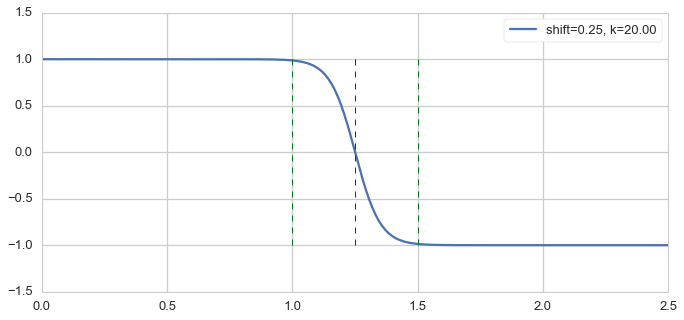

In [20]:
shift = 0.25
precision = 200
epsilon = 0.001
t_pres = 1
k_opt = np.log(2 / epsilon) / shift
k_round = 5 / shift
print('k_opt = %.4f, k_round = %.2f' % (k_opt, k_round))

x = np.linspace(-0, 2.5, precision)
y = 2/(1 + np.exp(k_round * ((x - t_pres) - shift))) - 1
yc = np.linspace(-1, 1, precision)
yc1 = [1.0] * precision
plt.figure(figsize=(10, 5))
sns.set(style='whitegrid', context='talk')
sns.set_color_codes('dark')
plt.plot(x, y, label='shift=%.2f, k=%.2f' % (shift, k_round))
plt.plot([t_pres + shift] * precision, yc, 'r--', lw=1.0)
plt.plot([t_pres] * precision, yc, 'g--', lw=1.0)
plt.plot([t_pres + 2 * shift] * precision, yc, 'g--', lw=1.0)
#plt.plot(x, [1.0] * precision, 'g--', lw=1.0)
axes = plt.gca()
axes.set_ylim([-1.5, 1.5])
plt.legend(frameon=True)
plt.show()

<a id='res'></a>

## Планирование пересылок резервом [ToC](#toc)

Есть случаи очень дальней пересылки локомотивов резервом. Такая пересылка нерациональна: за те много часов, которые локомотив едет, может случиться что угодно - и локомотив уже окажется ненужным. Поэтому предлагается ограничить "окно" пересылки локомотивов резервом: искать локомотивы только на станциях, до которых ехать сравнительно недолго. В качестве такого окна предлагается взять 15 часов, затем корректировать при необходимости.

#### Составляем таблицу с поездками локомотивов резервом

In [7]:
cols = ['loco', 'number', 'ser_name', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'train', 'n_state']
loco_plan['n_state'] = loco_plan.state.shift(-1)
loco_plan.loc[loco_plan.loco_end == True, 'n_state'] = -1
loco_plan_res = loco_plan[loco_plan.state == 0]
start_st = loco_plan_res.drop_duplicates(subset=['loco', 'train'])
end_st = loco_plan_res.drop_duplicates(subset=['loco', 'train'], keep='last')
trips = start_st[['loco', 'regions', 'train', 'number', 'ser_name', 'st_from_name', 'time_start']].set_index(['loco', 'train'])\
    .join(end_st[['loco', 'train', 'st_to_name', 'time_end', 'n_state']].set_index(['loco', 'train']))\
    .reset_index()[cols].sort_values('number')
    
trips['tt'] = np.round(((trips.time_end - trips.time_start) / 3600), 2)

# Загрузка "чистых" времен хода (не запланированных, без учета стоянок на смену бригад)
# Отсечка при планировании будет производиться именно по ним
default_tt = pd.read_csv(FOLDER + '/mandatory/travel_times_all_pairs.csv', sep=';')
def_tt = default_tt.set_index(['st_from_name', 'st_to_name']).to_dict()['tt']
trips['def_tt'] = trips.apply(lambda row: np.round(def_tt[(row.st_from_name, row.st_to_name)] / 3600, 2), axis=1)

cols = ['loco', 'number', 'ser_name', 'st_from_name', 'st_to_name', 'train', 'def_tt', 'tt']
nice_print(trips.sort_values('def_tt', ascending=False).head(), cols=cols)

AttributeError: 'DataFrame' object has no attribute 'loco_end'

#### Статистика по временам пересылок

In [ ]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(8, 4))
sns.kdeplot(trips.tt)

#### Поиск оптимальной границы

In [ ]:
# От Войтенко: список примерных предельных маршрутов для локомотивов резервом

res_lims = [('НАХОДКА-ВОСТОЧНАЯ', 'ХАБАРОВСК II'), ('ХАБАРОВСК II', 'БЕЛОГОРСК II'),
('БЕЛОГОРСК II', 'СКОВОРОДИНО'), ('СКОВОРОДИНО', 'КАРЫМСКАЯ'), ('КАРЫМСКАЯ', 'УЛАН-УДЭ'), 
('УЛАН-УДЭ', 'ИРКУТСК-СОРТИРОВОЧНЫЙ'), ('ИРКУТСК-СОРТИРОВОЧНЫЙ', 'ТАЙШЕТ'), 
('ТАЙШЕТ', 'КРАСНОЯРСК-ВОСТОЧНЫЙ'), ('КРАСНОЯРСК-ВОСТОЧНЫЙ', 'МАРИИНСК')]

In [ ]:
d = {}
for x in res_lims:
    d[x] = np.round(def_tt[x] / 3600, 2)    
lens = pd.DataFrame(d, index=np.arange(len(d.keys()))).transpose()[0]
print(lens.sort_values())

#### Подсчет локомотивов, время пересылки резервом которых лежит за границей

In [ ]:
lim_time = 15
print('Number of overtimed reserve trips: %d' % trips[trips.tt > lim_time].loco.count())
print('Part of overtimed reserve trips: %.4f' % (trips[trips.tt > lim_time].loco.count() / trips.loco.count()))

#### Локомотивы, которые пересылались резервом для проведения ТО

In [ ]:
cols = ['loco', 'number', 'ser_name', 'st_from_name', 'st_to_name', 'train', 'n_state', 'tt', 'def_tt']
res_to = trips[trips.n_state == 4]
res_to[res_to.def_tt > lim_time][cols].sort_values(['st_to_name', 'st_from_name'])

#### Выводы

1. В качестве верхней границы для времени пересылки локомотива резервом можно взять 15 часов. Из основных маршрутов локомотивов резервом такая отсечка сохранит все маршруты, кроме Сковородино - Карымская. Но по словам Войтенко, там возможна пересылка до Могочи. Впрочем, можно сделать исключение для локомотивов со станцией назначения Карымская в нечетном направлении - разрешить их пересылать при времени хода до 20 часов.
2. Всего в планах 20% от локомотивов, пересылающихся резервом, пересылаются на дальние расстояния (больше предельных 15 часов).
3. Пересылку на дальние расстояния резервом надо запретить и для пересылки на ТО. Впрочем, для любого положения локомотива наверняка найдется пункт ТО в радиусе этих 15 часов. Так что пока специальной проверки на это делать не надо. Имеющиеся случаи пересылки локомотивов на ТО с временем хода больше 15 часов - очень похожи на баги.

### Задачи на Костю:

1. [6664] Планируемое время хода не соответствует времени из ниток
2. [6501] У поездов без локомотивов и бригад не ищется нитка графика на первый участок маршрута
8. [6952] Возвращать из планировщика первую явку бригад, если она случилась по факту (мы ее не планировали)
  1. Для бригад в состояниях 2, 3, 4, 8 (это отдых или явка в депо приписки или в пункте оборота) мы сами планируем первые явки.
  2. Для бригад в остальных состояниях надо создавать ивент явки со state=2 и временем из сообщения fact-team-ready (время брать для явки того типа, который указан в поле ready-type).
7. Возвратные скачки по времени. Достаточно много у локомотивов.
3. Бригады в state = 2:
  1. Неверно планируются (практически не подвязываются под поезда):
    1. Выявить случаи очень ранней явки, проверить по операциям, что случилось с бригадами.
    2. Написать постановку на учет (подвязывать их как можно скорее, явку не переносить).
  2. Создаются фейковые бригады только со state=2.
10. Фиксация времени явки от предыдущего расчета.
4. При расчете времени отдыха бригады не учитывается, что явка могла быть до начала планирования.
  1. Проверить. Возможно, уже исправлено.
5. Явка бригады создается до начала планирования.
6. Бесцельная пересадка бригады с поезда на поезд.
  1. Выявить (по возможности) все такие случаи. 
9. Подвязывать поезда точно на нитки.
  1. Искать нитку на крупной станции, которую поезд проезжает без смены.